# Brazil Sao Paulo sugarcane crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. Our crop models use statistical or machine learning algorithms to predict crop yield of a speicific crop and regions. The accompanying Gro web app display for [Sao Paulo Sugarcane](https://app.gro-intelligence.com/displays/wZRlYJQ9B) provides an overview of the data series we will use to create a model to predict the sugar processing yield in Sao Paulo. 

## Preliminary
Here we use a `CropModel` object as well as some feature transformation functions. We also save the entity ids for the `item` [sugarcane](https://app.gro-intelligence.com/dictionary/items/538), `metric` [processing yield](https://app.gro-intelligence.com/dictionary/metrics/6881050), and for the `region` [Sao Paulo](https://app.gro-intelligence.com/dictionary/regions/10408).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.
In order to download data from our API, you need to set up a GROPI_TOKEN. Instructions are in this [wiki page](https://github.com/gro-intelligence/api-client/wiki/Authentication-Tokens#11-using-the-gro-web-application-preferred).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.ERROR) 
import os
import numpy as np
import pandas as pd
import itertools
import datetime

from api.client.crop_model import CropModel
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.cluster import KMeans

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
region_id = model.search_for_entity('regions', "Sao Paulo")
item_id =  model.search_for_entity('items', "sugarcane, TRS")

##  Historical Sugar Processing yields
To get the province-level sucrose yield data for sugarcane in Sao Paulo state, we set the entities (item, metric and region) and get the available data series.  The <em>source</em> for Sao Paulo sugarcane yields is [UNICA](https://app.gro-intelligence.com/dictionary/sources/47).

In [2]:
yield_entities = {}
yield_entities['item_id']  = item_id
yield_entities['region_id'] = region_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "processing yield mass/mass")
yield_entities['source_id'] = 47 # unica
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

There are 2 data series for {'item_id': 7539, 'region_id': 10408, 'metric_id': 6881050, 'source_id': 47}.
source_id 47: 2007-04-01T00:00:00.000Z to 2020-03-31T00:00:00.000Z
source_id 47: 2008-04-01T00:00:00.000Z to 2021-07-31T00:00:00.000Z


* As printed above, there are 2 available data series for the Sugar processing yield of Sao Paulo
* Next we retrieve the data frame of the sugarcane total recoverable sugar (TRS) series and make sure to subset to the metric (Processing Yield (mass/mass)), semi-monthly frequency and region (Sao Paulo) 

In [3]:
df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id']) & \
                  (df.frequency_id == 23)
                 ]
yield_df.end_date = pd.to_datetime(yield_df.end_date, utc=True)
yield_df['DOY']  = yield_df.end_date.apply(lambda x: int(x.strftime('%j')))
yield_df['Year'] = yield_df.end_date.apply(lambda x: x.year)
yield_df.sort_values(['Year', 'DOY']).tail()

,start_date,end_date,value,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year
264,2021-05-16 00:00:00+00:00,2021-05-31 00:00:00+00:00,137.49,867.0,867.0,1,NaT,2021-06-10 00:00:00+00:00,6881050,7539,10408,0,23,47,151,2021
265,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1,NaT,2021-06-25 00:00:00+00:00,6881050,7539,10408,0,23,47,166,2021
266,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1,NaT,2021-07-12 00:00:00+00:00,6881050,7539,10408,0,23,47,181,2021
267,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1,NaT,2021-07-27 00:00:00+00:00,6881050,7539,10408,0,23,47,196,2021
268,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1,NaT,2021-08-10 00:00:00+00:00,6881050,7539,10408,0,23,47,212,2021


* The resulting data frame includes information on the start and end date of the periods corresponding to each processing yield observation, and ids representing the frequency, unit, unit scale, item, metric, and region of our Gro data series. 
**Note**: the unit used here for TRS is kg/ton or kilograms per **US short ton**, not the metric tonnes. 
* The Day of Year and Year columns are derived from the end_date column to help with feature transformation processing

* A scatter plot helps us visualize the progression of the TRS processing yield over time. We suspect that it follows similar seasonal patterns in all years and more recent years might be higher in TRS than years further back. 
* So, we plot the following figure of TRS versus the day of year and color coded by year.  

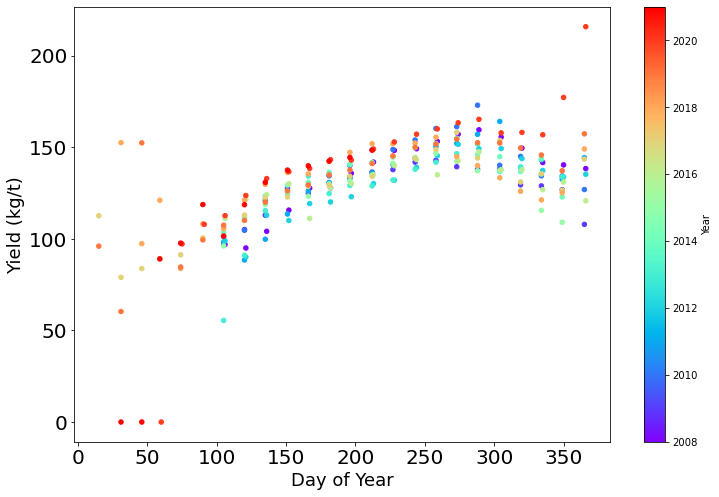

In [4]:
fig, axes = plt.subplots(1, 1)
yield_df[yield_df['value']<300].plot(x='DOY', y='value', kind='scatter', c='Year', 
                                     cmap='rainbow', ax=axes, figsize=(12,8), fontsize=20, legend=True)
plt.xlabel("Day of Year", fontsize=18)
plt.ylabel("Yield (kg/t)", fontsize=18)
plt.show()

* As we can see in this figure above, the sugar processing yield follows an increasing pattern from the Day of year (DOY) 100 to about 270 and then goes back down 
* The processing yield between the DOY 350 and DOY 100 of the following year appear to show no pattern, and there are only data points for recent years
* For the purpose of this analysis, we therefore limit the study period to between the DOY 100 and 350
* **Note**: It is possible to limit the time period of the data being pulled. You just need to specify `'start_date'` and `'end_date'` in the entities dictionary that we used earlier as inputs to the CropModel <i>get_data_series<i> method

In [5]:
df_within_range = yield_df[(yield_df['DOY'] > 100) & (yield_df['DOY'] < 350)]
df_within_range

,start_date,end_date,value,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year
0,2008-04-01 00:00:00+00:00,2008-04-15 00:00:00+00:00,96.89,867.0,867.0,1,NaT,2018-08-20 00:00:00+00:00,6881050,7539,10408,0,23,47,106,2008
1,2008-04-16 00:00:00+00:00,2008-04-30 00:00:00+00:00,94.98,867.0,867.0,1,NaT,2018-08-20 00:00:00+00:00,6881050,7539,10408,0,23,47,121,2008
2,2008-05-01 00:00:00+00:00,2008-05-15 00:00:00+00:00,104.10,867.0,867.0,1,NaT,2018-08-20 00:00:00+00:00,6881050,7539,10408,0,23,47,136,2008
3,2008-05-16 00:00:00+00:00,2008-05-31 00:00:00+00:00,115.66,867.0,867.0,1,NaT,2018-08-20 00:00:00+00:00,6881050,7539,10408,0,23,47,152,2008
4,2008-06-01 00:00:00+00:00,2008-06-15 00:00:00+00:00,127.62,867.0,867.0,1,NaT,2018-08-20 00:00:00+00:00,6881050,7539,10408,0,23,47,167,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2021-05-16 00:00:00+00:00,2021-05-31 00:00:00+00:00,137.49,867.0,867.0,1,NaT,2021-06-10 00:00:00+00:00,6881050,7539,10408,0,23,47,151,2021
265,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1,NaT,2021-06-25 00:00:00+00:00,6881050,7539,10408,0,23,47,166,2021
266,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1,NaT,2021-07-12 00:00:00+00:00,6881050,7539,10408,0,23,47,181,2021
267,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1,NaT,2021-07-27 00:00:00+00:00,6881050,7539,10408,0,23,47,196,2021


* In case of making a TRS forecast for a period in the future, we generate an additional dataframe of the new dates. For example, here we add a date that occurs 15 days after the most recent available TRS period in order to make a forecast for that period.

In [6]:
# date to predict
new_date = df_within_range['end_date'].max() + datetime.timedelta(days=15)
print(new_date.strftime('%Y-%m-%d'))

2021-08-15


In [7]:
# expand the df_within_range with this new date
unknown_df = df_within_range.set_index('end_date').reindex([new_date]).reset_index()
unknown_df['DOY']  = unknown_df.end_date.apply(lambda x: int(x.strftime('%j')))
unknown_df['Year'] = unknown_df.end_date.apply(lambda x: x.year)
df_within_range = pd.concat([df_within_range, unknown_df
                             ], ignore_index=True)


* Next, convert the end_date column to datetime 
* Convert the DOY and Year columns to integers type

In [8]:
df_within_range['end_date'] = pd.to_datetime(df_within_range['end_date'], utc=True)
df_within_range.DOY = df_within_range.DOY.astype(int)
df_within_range.Year = df_within_range.Year.astype(int)
df_within_range.rename(columns={'value': 'TRS'}, inplace=True)
df_within_range.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021


## NDVI of Sao Paulo
The main signal we will use to model TRS yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for vegetative growth (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [9]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3


entities['region_id'] = region_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

In [10]:
df = model.get_df()
raw_ndvi = df[(df['item_id'] == entities['item_id']) & (df['metric_id']==entities['metric_id'])]
raw_ndvi.head()

,start_date,end_date,value,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id
0,2000-02-18 00:00:00+00:00,2000-02-25 00:00:00+00:00,0.740052,189.0,189.0,1,NaT,2019-12-13 00:00:00+00:00,70029,321,10408,0,3,3
1,2000-02-26 00:00:00+00:00,2000-03-04 00:00:00+00:00,0.695881,189.0,189.0,1,NaT,2019-12-13 00:00:00+00:00,70029,321,10408,0,3,3
2,2000-03-05 00:00:00+00:00,2000-03-12 00:00:00+00:00,0.691287,189.0,189.0,1,NaT,2019-11-09 00:00:00+00:00,70029,321,10408,0,3,3
3,2000-03-13 00:00:00+00:00,2000-03-20 00:00:00+00:00,0.688005,189.0,189.0,1,NaT,2019-11-09 00:00:00+00:00,70029,321,10408,0,3,3
4,2000-03-21 00:00:00+00:00,2000-03-28 00:00:00+00:00,0.712438,189.0,189.0,1,NaT,2019-11-09 00:00:00+00:00,70029,321,10408,0,3,3


* A quick way to summarize the statistics of this NDVI dataframe is to use the *describe()* method.
* As shown in the table below, there are 979 data points and the mean NDVI value is 0.63 with a standard deviation of 0.079, a min of 0.40, and a max of 0.76.

In [11]:
raw_ndvi.describe()

,value,unit_id,input_unit_id,input_unit_scale,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id
count,980.000000,980.0,980.0,980.0,980.0,980.0,980.0,980.0,980.0,980.0
mean,0.630160,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0
std,0.079716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.404479,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0
25%,0.564379,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0
50%,0.646920,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0
75%,0.700508,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0
max,0.759790,189.0,189.0,1.0,70029.0,321.0,10408.0,0.0,3.0,3.0


* The start and end dates of individual NDVI periods do not match with that of the Sugar processing yield periods because NDVI data is reported in 8-day periods while the TRS series is reported in 15-day periods.
* In order to synchronize these two data series, we transform the NDVI data to a daily time step first and then pick the NDVI value that corresponds to the sugar processing yield data periods' end dates.
* The way we transform NDVI is a linear interpolation method. The reasoning is that NDVI is an indicator of the amount of biomass, which generally varies continuously as the vegetation grows.

In [12]:
# set constants to be used for all features
date_index = 'end_date'
startday = 100
endday = 350
region_index='region_id'
feature = 'value'

In [13]:
# transform the 8-day data into a daily dataframe

raw_ndvi[date_index] = pd.to_datetime(raw_ndvi[date_index], utc=True)
min_date = raw_ndvi[date_index].min()
max_date = pd.to_datetime("{}-{}".format(raw_ndvi[date_index].max().year, endday), 
                          format='%Y-%j', utc=True)
date_range = pd.date_range(min_date, max_date, freq='D', name=date_index)
raw_ndvi_pivot = raw_ndvi.pivot_table(index=date_index, columns=region_index, values=feature)

raw_ndvi_filled = raw_ndvi_pivot.reset_index().set_index(date_index).reindex(
    date_range).asfreq('D').interpolate(
    method='linear',limit_direction='forward', axis=0).stack(   
    region_index).reset_index(name=feature)
raw_ndvi_filled.describe()

,region_id,value
count,7966.0,7966.000000
mean,10408.0,0.627707
std,0.0,0.080566
min,10408.0,0.404479
25%,10408.0,0.558634
50%,10408.0,0.643511
75%,10408.0,0.699447
max,10408.0,0.759790


* The data frame printed above shows the result of applying linear interpolation of NDVI from 8-day periods to daily timestep
* Next, subset the NDVI data to our study timeframe between the DOY 100 and 350

In [14]:
# Get the Doy of year (DOY) as well as Year from the date index
raw_ndvi_filled.loc[:, 'doy'] = raw_ndvi_filled[date_index].dt.dayofyear
raw_ndvi_filled.loc[:, 'year'] = raw_ndvi_filled[date_index].dt.year
ndvi_within_range = raw_ndvi_filled[(raw_ndvi_filled['doy'] > 100) & (
    raw_ndvi_filled['doy'] < 350)]


* And then merge together the NDVI data frame with the TRS or sugar processing yield data frame.
* Keep the NDVI values of the dates that match with the TRS period end dates.

In [15]:
ndvi_within_range.rename(columns={'value': 'ndvi'}, inplace=True)
ndvi_df = ndvi_within_range[ndvi_within_range['year'].isin(df_within_range['Year'].unique())]


ndvi_df.loc[:, 'DOY'] = ndvi_df.doy.astype(int)
ndvi_df.loc[:, 'Year'] = ndvi_df.year.astype(int)

ndvi_y = df_within_range[['DOY','Year','TRS']].merge(ndvi_df[['end_date','doy','year', 'ndvi']],
                        left_on=['DOY','Year'], right_on= ['doy','year'], how='left')
ndvi_y.tail()


,DOY,Year,TRS,end_date,doy,year,ndvi
221,166,2021,139.81,2021-06-15 00:00:00+00:00,166,2021,0.604017
222,181,2021,142.40,2021-06-30 00:00:00+00:00,181,2021,0.585421
223,196,2021,144.39,2021-07-15 00:00:00+00:00,196,2021,0.532632
224,212,2021,148.36,2021-07-31 00:00:00+00:00,212,2021,0.490127
225,227,2021,NaN,2021-08-15 00:00:00+00:00,227,2021,0.487106


* A scatter plot of TRS versus NDVI that is color coded by the Day of Year (DOY) indicates: the relationship between the two variables along with different patterns or relationships during different periods of the year.

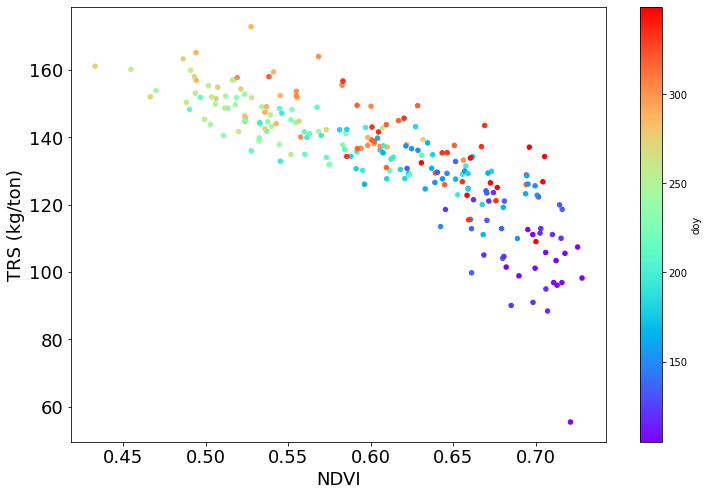

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
        
ndvi_y.plot(x='ndvi', y='TRS', c='doy', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('NDVI', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

* As shown in this figure above, there is an inverse relationship between the content of Total Recoverable Sugar (TRS) and the NDVI values.
* This negative correlation has greater magnitude (a steeper slope) during earlier DOY than the rest of the year

### Daily FEWS_PET versus Sugar Content
In addition to NDVI, there are various climate features that may be able to capture variation in the sugar processing yield. The potential evapotranspiration is one important measurement: [FEWS_PET](https://app.gro-intelligence.com/dictionary/items/5072)

In [17]:
entities = {}
entities['item_id'] =  5072
entities['metric_id'] = 4660031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 44
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


In [18]:
model.get_df()
raw_pet = model._data_frame[model._data_frame['metric_id'] == 4660031]
raw_pet.tail()


,start_date,end_date,value,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id
7498,2021-08-06 00:00:00+00:00,2021-08-06 00:00:00+00:00,3.411164,2.0,2.0,1,NaN,2021-08-08 00:00:00+00:00,4660031,5072,10408,0,1,44
7499,2021-08-07 00:00:00+00:00,2021-08-07 00:00:00+00:00,3.806156,2.0,2.0,1,NaN,2021-08-09 00:00:00+00:00,4660031,5072,10408,0,1,44
7500,2021-08-08 00:00:00+00:00,2021-08-08 00:00:00+00:00,3.789127,2.0,2.0,1,NaN,2021-08-10 00:00:00+00:00,4660031,5072,10408,0,1,44
7501,2021-08-09 00:00:00+00:00,2021-08-09 00:00:00+00:00,3.826979,2.0,2.0,1,NaN,2021-08-11 00:00:00+00:00,4660031,5072,10408,0,1,44
7502,2021-08-10 00:00:00+00:00,2021-08-10 00:00:00+00:00,4.125917,2.0,2.0,1,NaN,2021-08-12 00:00:00+00:00,4660031,5072,10408,0,1,44


In [19]:
raw_pet.loc[:, date_index] = pd.to_datetime(raw_pet[date_index], utc=True)

raw_pet.loc[:, 'doy'] = raw_pet[date_index].dt.dayofyear
raw_pet.loc[:, 'year'] = raw_pet[date_index].dt.year


* Since PET is available at daily time step, we are able to directly aggregate it to match with the same periods of the Sugar processing yield or TRS dataset.
* First, merge the DOY information from the TRS dataset, and then aggregate PET (sum) to those periods.

In [20]:
START_YEAR = df_within_range['Year'].min()

pet_agg = raw_pet[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
pet_agg = pet_agg[pet_agg['year'] >= START_YEAR][pet_agg['doy']>=100][pet_agg['doy']<=350]
pet_grouped = pet_agg.fillna(method='bfill').groupby(['year','DOY']).sum().reset_index()

pet_y = df_within_range.merge(pet_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
pet_y.sort_values(['Year','DOY']).tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,37.688121,2021.0
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,39.996158,2021.0
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,43.016164,2021.0
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,51.318742,2021.0
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,NaN,NaN


* Next we use a color coded scatter plot to show the relationship between TRS and PET.

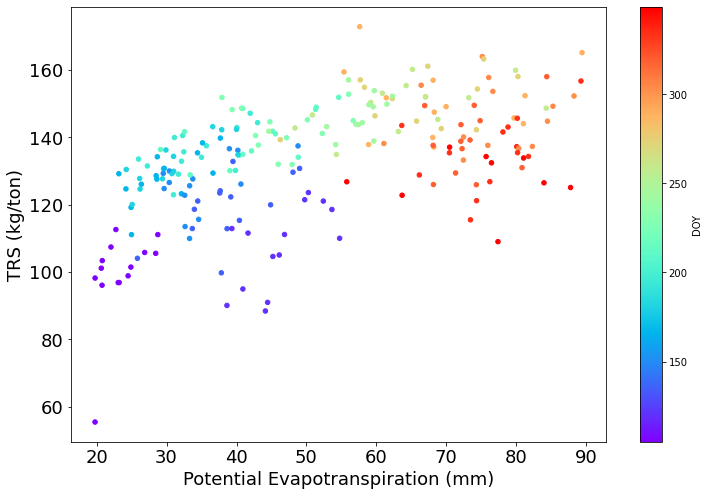

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
        
pet_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Potential Evapotranspiration (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* There appears to be a positive relationship between TRS and PET for the DOY between 170 to 260.
* The rest of the days of a year appeared to show a much weaker relationship.

### Daily GPM precipitation with/without GFS weather forecast versus Sugar Content
Daily precipitation is another weather variable that proved to be important to the sugar processing yield.
GPM provides actually measured daily weather data while GFS gives daily forecasted weather data including precipitation. 
Since GFS forecasts future precipitation up to about two weeks from today, it presumably improves predictions of sugar yield by incorporating this feature. 
[GPM](https://app.gro-intelligence.com/dictionary/sources/126)
[GFS](https://app.gro-intelligence.com/dictionary/sources/105)
[Precipitation](https://app.gro-intelligence.com/dictionary/items/10081)

In [22]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 126 # GPM
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    if data_series['region_id']==region_id:
        model.add_single_data_series(data_series)


In [23]:
model.get_df()
raw_gpm = model._data_frame[model._data_frame['metric_id'] == 2100031]
raw_gpm.loc[:, date_index] = pd.to_datetime(raw_gpm[date_index], utc=True)

raw_gpm.loc[:, 'doy'] = raw_gpm[date_index].dt.dayofyear
raw_gpm.loc[:, 'year'] = raw_gpm[date_index].dt.year
raw_gpm.tail()

,start_date,end_date,value,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,doy,year
7736,2021-08-06 00:00:00+00:00,2021-08-06 00:00:00+00:00,1.214129,2.0,2.0,1,2021-08-07 14:43:00+00:00,2021-08-07 19:14:35+00:00,2100031,2039,10408,0,1,126,218,2021
7737,2021-08-07 00:00:00+00:00,2021-08-07 00:00:00+00:00,0.265617,2.0,2.0,1,2021-08-08 14:43:00+00:00,2021-08-08 18:14:43+00:00,2100031,2039,10408,0,1,126,219,2021
7738,2021-08-08 00:00:00+00:00,2021-08-08 00:00:00+00:00,0.019297,2.0,2.0,1,2021-08-09 14:45:00+00:00,2021-08-09 19:12:59+00:00,2100031,2039,10408,0,1,126,220,2021
7739,2021-08-09 00:00:00+00:00,2021-08-09 00:00:00+00:00,0.001942,2.0,2.0,1,2021-08-10 14:44:00+00:00,2021-08-10 18:13:05+00:00,2100031,2039,10408,0,1,126,221,2021
7740,2021-08-10 00:00:00+00:00,2021-08-10 00:00:00+00:00,0.005157,2.0,2.0,1,2021-08-11 14:43:00+00:00,2021-08-11 18:14:33+00:00,2100031,2039,10408,0,1,126,222,2021


* Similar to PET, GPM is also a data source at the daily timestep. So, we follow a similar procedure to aggregate (sum) it to the same periods as the TRS dataset.

In [24]:
gpm_agg = raw_gpm[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')

gpm_agg = gpm_agg[gpm_agg['year'] >= START_YEAR][gpm_agg['doy']>=100][gpm_agg['doy']<=350]


gpm_grouped = gpm_agg.fillna(method='bfill').groupby(['DOY','year']).sum().reset_index()

gpm_y = df_within_range.merge(gpm_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
gpm_y.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,83.784042,2021.0
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,18.828690,2021.0
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,0.297834,2021.0
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,25.907467,2021.0
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,NaN,NaN


* Next, we use a scatter plot to show the relationship between TRS and GPM precipitation.

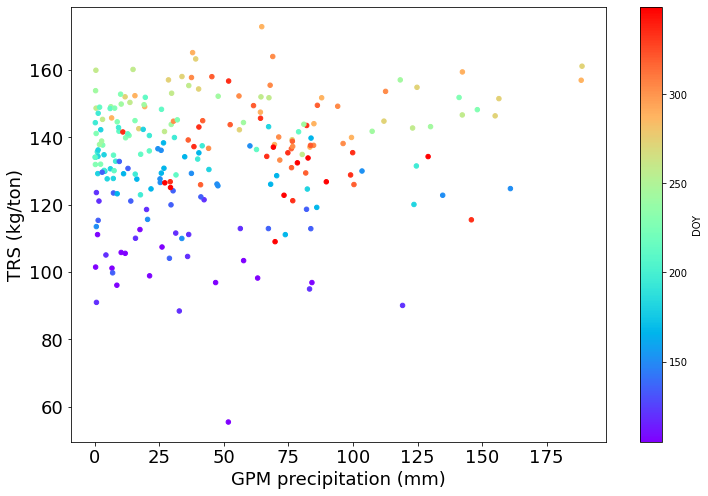

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
        
gpm_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('GPM precipitation (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

* As shown in the scatter plot above, there appears to be a mild negative relationship between TRS and GPM precipitation in the period following DOY 300 and in the period preceding DOY 200.


Next, we obtain GFS data using the same method as GPM.

In [26]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 105   #GFS
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

In [27]:
model.get_df()
raw_gfs = model._data_frame[(model._data_frame['metric_id'] == 2100031) & 
                            (model._data_frame['item_id'] == 2039)]
raw_gfs[date_index] = pd.to_datetime(raw_gfs[date_index], utc=True)

raw_gfs.loc[:, 'doy'] = raw_gfs[date_index].dt.dayofyear
raw_gfs.loc[:, 'year'] = raw_gfs[date_index].dt.year

raw_gfs.describe()

,value,unit_id,input_unit_id,input_unit_scale,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,doy,year
count,512285.000000,512285.0,512285.0,512285.0,512285.0,512285.0,5.122850e+05,512285.0,512285.0,512285.000000,512285.000000,512285.000000
mean,3.443205,2.0,2.0,1.0,2100031.0,2039.0,2.360155e+05,0.0,1.0,105.317325,185.248139,2019.934388
std,6.868796,0.0,0.0,0.0,0.0,0.0,3.575856e+06,0.0,0.0,2.561864,102.400568,1.564639
min,0.000000,2.0,2.0,1.0,2100031.0,2039.0,1.040800e+04,0.0,1.0,105.000000,1.000000,2000.000000
25%,0.000000,2.0,2.0,1.0,2100031.0,2039.0,1.094270e+05,0.0,1.0,105.000000,98.000000,2020.000000
50%,0.109677,2.0,2.0,1.0,2100031.0,2039.0,1.095910e+05,0.0,1.0,105.000000,193.000000,2020.000000
75%,3.879375,2.0,2.0,1.0,2100031.0,2039.0,1.097570e+05,0.0,1.0,105.000000,268.000000,2021.000000
max,161.915629,2.0,2.0,1.0,2100031.0,2039.0,1.000224e+08,0.0,1.0,126.000000,366.000000,2021.000000


* Similar to GPM,  we can aggregate (sum) GFS data to the same periods as the TRS dataset.

In [28]:
gfs_agg = raw_gfs[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')

gfs_agg = gfs_agg[gfs_agg['year'] >= START_YEAR][gfs_agg['doy']>=100][gfs_agg['doy']<=350]


gfs_grouped = gfs_agg.fillna(method='bfill').groupby(['DOY','year']).sum().reset_index()

gfs_y = df_within_range.merge(gfs_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
gfs_y.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,8450.369562,2021
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,2170.954252,2021
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,5071.278858,2021
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,5033.110500,2021
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,1191.405610,2021


* Next, we use a scatter plot to show the relationship between TRS and GFS precipitation.

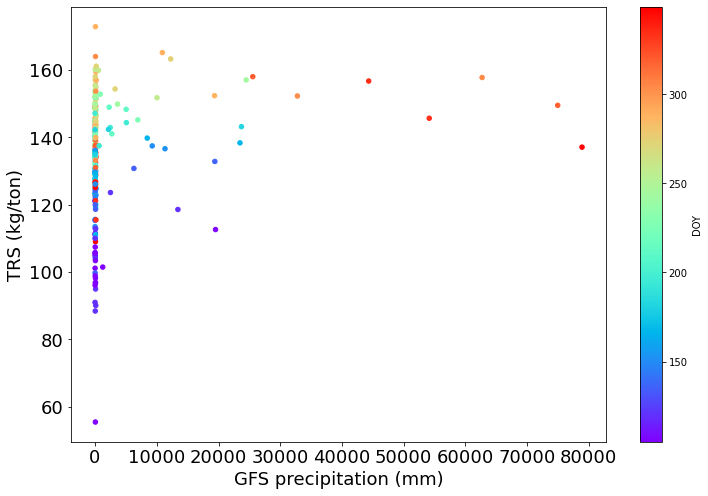

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
        
gfs_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('GFS precipitation (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

* As shown in the scatter plot above, there appears to be a mild negative relationship between TRS and GFS precipitation in the period preceding DOY 200. Unlike GPM, it does not show negative relationship for the period of over 300 DOY.

Now, we merge GFS with GPM. For the future dates from today where actual GPM precipitation data is not availabe, we pad it with the forecasted precipitation from GFS.


In [30]:
raw_gpm1 = raw_gpm[['year','doy','value']].rename(columns={'value':'gpm'})
raw_gfs1 = raw_gfs[['year','doy','value']].rename(columns={'value':'gfs'})

df = raw_gfs1.merge(raw_gpm1, left_on=['doy','year'], right_on=['doy', 'year'], how='left')
df['value']=df['gpm'].fillna(df.gfs)
df[-24:]

,year,doy,gfs,gpm,value
512261,2021,216,0.080230,0.074634,0.074634
512262,2021,217,0.016434,1.508846,1.508846
512263,2021,218,0.056474,1.214129,1.214129
512264,2021,219,0.090193,0.265617,0.265617
512265,2021,220,0.002882,0.019297,0.019297
512266,2021,221,0.000000,0.001942,0.001942
512267,2021,222,0.000124,0.005157,0.005157
512268,2021,223,0.314800,NaN,0.314800
512269,2021,224,0.369791,NaN,0.369791
512270,2021,225,0.428977,NaN,0.428977


* For year 2020, GPM has data up to DOY 202 (the day before running date) while GFS has data up to DOY 219, which has 17 days more.
* For DOY from 1 to 202, predicted precipitation (GFS) is typically different from actual precipitaion (GPM) - there is no general pattern between these 2 data series.
* For DOY greater than 202, the predited precipitations are zero fom some days. This may suggest that GFS does not have sufficient data to make a prediction.

At this point, both GPM and GFS data are ready. you can run models with/without GFS forecast data.
Note that we are not using GFS to replace GPM. Rather, we use GFS data only for the future dates where GPM data are not available.

In [31]:

gfs_agg = df[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')

gfs_agg = gfs_agg[gfs_agg['year'] >= START_YEAR][gfs_agg['doy']>=100][gfs_agg['doy']<=350]


gfs_grouped = gfs_agg.fillna(method='bfill').groupby(['DOY','year']).sum().reset_index()

gfs_y = df_within_range.merge(gfs_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
gfs_y.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,54124.491283,2021
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,12163.333475,2021
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,4936.019627,2021
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,16736.223401,2021
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,4347.575038,2021


### Daily LST temperature versus Sugar Content
The Land Surface Temperature ([LST](https://app.gro-intelligence.com/dictionary/sources/26)) is a daily timestep temperature data source.


In [32]:
entities = {}
entities['item_id'] =  3457
entities['metric_id'] = 2540047
entities['region_id'] = region_id
entities['frequency_id']= 1

for data_series in model.get_data_series(**entities):
    if data_series['region_id'] == region_id :
        model.add_single_data_series(data_series)


* Again, we aggregate (average) the LST temperature data to the same periods as the TRS sugar processing yield data.

In [33]:
model.get_df()
raw_lst = model._data_frame[model._data_frame['metric_id'] == entities['metric_id']]
print(raw_lst.end_date.unique())
raw_lst.loc[:, date_index] = pd.to_datetime(raw_lst[date_index], utc=True)

raw_lst.loc[:, 'doy'] = raw_lst[date_index].dt.dayofyear
raw_lst.loc[:, 'year'] = raw_lst[date_index].dt.year

raw_lst.describe()

<DatetimeArray>
['2000-02-25 00:00:00+00:00', '2000-02-26 00:00:00+00:00',
 '2000-02-27 00:00:00+00:00', '2000-02-28 00:00:00+00:00',
 '2000-02-29 00:00:00+00:00', '2000-03-01 00:00:00+00:00',
 '2000-03-02 00:00:00+00:00', '2000-03-03 00:00:00+00:00',
 '2000-03-04 00:00:00+00:00', '2000-03-05 00:00:00+00:00',
 ...
 '2021-08-01 00:00:00+00:00', '2021-08-02 00:00:00+00:00',
 '2021-08-03 00:00:00+00:00', '2021-08-05 00:00:00+00:00',
 '2021-08-06 00:00:00+00:00', '2021-08-07 00:00:00+00:00',
 '2021-08-08 00:00:00+00:00', '2021-08-09 00:00:00+00:00',
 '2021-08-10 00:00:00+00:00', '2021-08-11 00:00:00+00:00']
Length: 6264, dtype: datetime64[ns, UTC]


,value,unit_id,input_unit_id,input_unit_scale,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,doy,year
count,6264.000000,6264.0,6264.0,6264.0,6264.0,6264.0,6264.0,6264.0,6264.0,6264.0,6264.000000,6264.000000
mean,28.068235,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,180.906450,2010.468391
std,4.153308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.012399,6.217565
min,11.534710,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,1.000000,2000.000000
25%,25.385270,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,99.000000,2005.000000
50%,28.118230,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,181.000000,2011.000000
75%,30.829659,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,261.000000,2016.000000
max,42.723178,36.0,36.0,1.0,2540047.0,3457.0,10408.0,0.0,1.0,26.0,366.000000,2021.000000


In [34]:
lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
lst_agg = lst_agg[lst_agg['year'] >= START_YEAR][lst_agg['doy']>=100][lst_agg['doy']<=350]


lst_grouped = lst_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

lst_y = df_within_range.merge(lst_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
lst_y.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,24.627417,2021.0
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,23.181575,2021.0
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,23.316257,2021.0
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,22.262522,2021.0
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,NaN,NaN


* Again, we plot a scatter plot of TRS versus LST to visualize the relationship between total recoverable sugar and the land surface temperature.

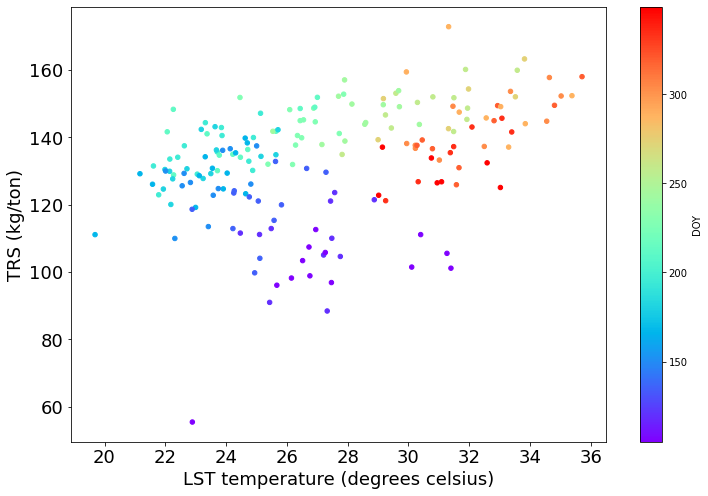

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
        
lst_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('LST temperature (degrees celsius)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* The LST appears to be positively correlated with the TRS, especially for the DOY between 170 and 270

### Daily GDI temperature versus Sugar Content
The Gro Drought Index is a propriatory data series derived by Gro that quantifies the drought severity ([GDI](https://app.gro-intelligence.com/dictionary/sources/145)) is a daily timestep temperature data source.


In [36]:
entities = {}
entities['item_id'] =  17388 # drought index has its own item_id
entities['metric_id'] = 15852252
entities['region_id'] = region_id
entities['frequency_id']= 1

for data_series in model.get_data_series(**entities):
    if data_series['region_id'] == region_id :
        model.add_single_data_series(data_series)


* Again, we aggregate (average) the GDI data to the same periods as the TRS sugar processing yield data.

In [37]:
model.get_df()
raw_gdi = model._data_frame[model._data_frame['metric_id'] == entities['metric_id']]
print(raw_gdi.end_date.unique())
raw_gdi.loc[:, date_index] = pd.to_datetime(raw_gdi[date_index], utc=True)

raw_gdi.loc[:, 'doy'] = raw_gdi[date_index].dt.dayofyear
raw_gdi.loc[:, 'year'] = raw_gdi[date_index].dt.year

raw_gdi.describe()

<DatetimeArray>
['2003-01-31 00:00:00+00:00', '2003-02-01 00:00:00+00:00',
 '2003-02-02 00:00:00+00:00', '2003-02-03 00:00:00+00:00',
 '2003-02-04 00:00:00+00:00', '2003-02-05 00:00:00+00:00',
 '2003-02-06 00:00:00+00:00', '2003-02-07 00:00:00+00:00',
 '2003-02-08 00:00:00+00:00', '2003-02-09 00:00:00+00:00',
 ...
 '2021-08-01 00:00:00+00:00', '2021-08-02 00:00:00+00:00',
 '2021-08-03 00:00:00+00:00', '2021-08-04 00:00:00+00:00',
 '2021-08-05 00:00:00+00:00', '2021-08-06 00:00:00+00:00',
 '2021-08-07 00:00:00+00:00', '2021-08-08 00:00:00+00:00',
 '2021-08-09 00:00:00+00:00', '2021-08-10 00:00:00+00:00']
Length: 6746, dtype: datetime64[ns, UTC]


,value,unit_id,input_unit_id,input_unit_scale,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,doy,year
count,6746.000000,6746.0,6746.0,6746.0,6746.0,6746.0,6746.0,6746.0,6746.0,6746.0,6746.000000,6746.000000
mean,0.733621,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,181.805811,2011.853988
std,0.691637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.491920,5.360664
min,0.012000,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,1.000000,2003.000000
25%,0.239000,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,92.000000,2007.000000
50%,0.495000,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,180.000000,2012.000000
75%,0.971000,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,272.000000,2016.000000
max,3.474000,189.0,189.0,1.0,15852252.0,17388.0,10408.0,0.0,1.0,145.0,365.000000,2021.000000


In [38]:
gdi_agg = raw_gdi[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
gdi_agg = gdi_agg[gdi_agg['year'] >= START_YEAR][gdi_agg['doy']>=100][gdi_agg['doy']<=350]


gdi_grouped = gdi_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

gdi_y = df_within_range.merge(gdi_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
gdi_y.tail()

,start_date,end_date,TRS,unit_id,input_unit_id,input_unit_scale,reporting_date,available_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id,DOY,Year,value,year
221,2021-06-01 00:00:00+00:00,2021-06-15 00:00:00+00:00,139.81,867.0,867.0,1.0,NaT,2021-06-25 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,166,2021,2.625467,2021.0
222,2021-06-16 00:00:00+00:00,2021-06-30 00:00:00+00:00,142.40,867.0,867.0,1.0,NaT,2021-07-12 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,181,2021,2.546667,2021.0
223,2021-07-01 00:00:00+00:00,2021-07-15 00:00:00+00:00,144.39,867.0,867.0,1.0,NaT,2021-07-27 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,196,2021,2.608533,2021.0
224,2021-07-16 00:00:00+00:00,2021-07-31 00:00:00+00:00,148.36,867.0,867.0,1.0,NaT,2021-08-10 00:00:00+00:00,6881050.0,7539.0,10408.0,0.0,23.0,47.0,212,2021,2.677562,2021.0
225,NaT,2021-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,227,2021,NaN,NaN


* Again, we plot a scatter plot of TRS versus GDI to visualize the relationship between total recoverable sugar and the drought index.

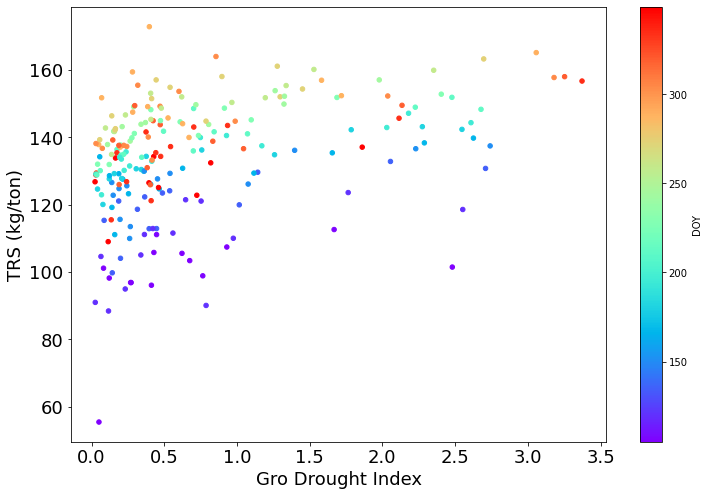

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
        
gdi_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Gro Drought Index', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* Theree appears to be a weak positive correlation between TRS and GDI 

### Merge the variables together and assess the relationships among them

In [40]:
pet_y.rename(columns={'value': 'pet'}, inplace=True)
gpm_y.rename(columns={'value': 'gpm'}, inplace=True)
lst_y.rename(columns={'value': 'lst'}, inplace=True)
gdi_y.rename(columns={'value': 'gdi'}, inplace=True)
pet_y.DOY = pet_y.DOY.astype(int)
gpm_y.DOY = gpm_y.DOY.astype(int)
lst_y.DOY = lst_y.DOY.astype(int)
gdi_y.DOY = gdi_y.DOY.astype(int)
df_tog = ndvi_y.merge(pet_y[['pet', 'DOY','year']], on=['DOY', 'year'], how='left')\
               .merge(gpm_y[['gpm', 'DOY','year']], on=['DOY', 'year'], how='left')\
               .merge(lst_y[['lst', 'DOY','year']], on=['DOY', 'year'], how='left')\
               .merge(gdi_y[['gdi', 'DOY','year']], on=['DOY', 'year'], how='left')

df_tog.sort_values(['year','DOY'], ascending=True).tail()

,DOY,Year,TRS,end_date,doy,year,ndvi,pet,gpm,lst,gdi
221,166,2021,139.81,2021-06-15 00:00:00+00:00,166,2021,0.604017,37.688121,83.784042,24.627417,2.625467
222,181,2021,142.40,2021-06-30 00:00:00+00:00,181,2021,0.585421,39.996158,18.828690,23.181575,2.546667
223,196,2021,144.39,2021-07-15 00:00:00+00:00,196,2021,0.532632,43.016164,0.297834,23.316257,2.608533
224,212,2021,148.36,2021-07-31 00:00:00+00:00,212,2021,0.490127,51.318742,25.907467,22.262522,2.677562
225,227,2021,NaN,2021-08-15 00:00:00+00:00,227,2021,0.487106,NaN,NaN,NaN,NaN


<AxesSubplot:>

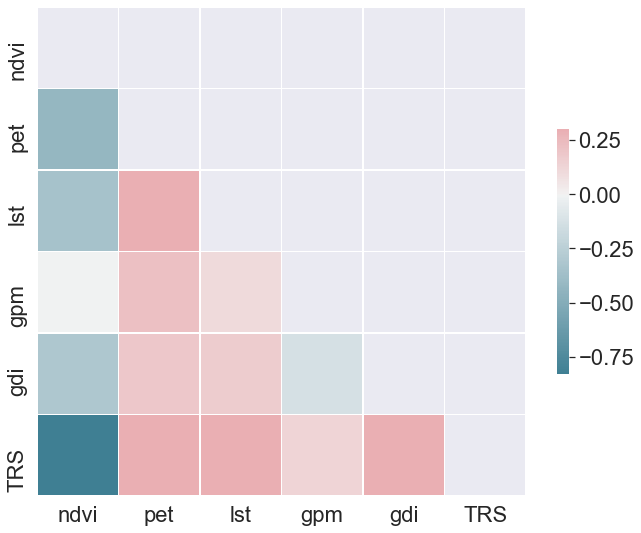

In [41]:

corr = df_tog[['ndvi','pet','lst', 'gpm', 'gdi', 'TRS']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2) 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* NDVI is not correlated with precipitation and negatively correlated with LST and PET.
* PET, as a modeled product with temperature and precipitation as major inputs, is positively correlated with LST and GPM.
* Temperature appears to be mildly positively correlated with precipitation, which is because the dry season corresponds to the winter or colder season in the southern atmosphere, or Sao Paulo here.
* GDI is negatively correlated with GPM precipiation data, yet both GPM and GDI have a positive correlation with TRS. It could be that the relationship between TRS and precipitation or dryness level changes according to the growth stages of sugar.

### Cluster the points to find the distinct periods during the season
* The previous scatter plots between TRS and weather variables manifested three clusters of DOY periods.
* Because of such differing responses of TRS to weather conditions at different time of the year, it is appropriate to model those three periods separately.
* First, we need to clearly define the boundaries of those three clusters, and KMeans is a simple clustering method to do so.

In [42]:
input_vars = ['ndvi', 'pet', 'lst', 'gpm', 'gdi']
X = np.array(df_tog[input_vars + ['TRS','DOY']].dropna())
f_names = input_vars + ['TRS','DOY']
kmeans = KMeans(3)
kmeans.fit(X)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

* Add a variable name `group` to record the KMeans clustering result, as printed below

In [43]:
data_decision = pd.DataFrame(X)
data_decision.columns = f_names
data_decision['group'] = y_km
data_decision.head()

,ndvi,pet,lst,gpm,gdi,TRS,DOY,group
0,0.679789,25.817958,25.110343,28.980030,0.198133,104.10,136.0,1
1,0.620524,26.142522,23.242788,7.257239,0.206400,127.81,182.0,2
2,0.591495,32.461089,23.706658,1.079680,0.236400,135.72,197.0,2
3,0.536887,45.161768,25.642185,9.449393,0.494188,141.85,213.0,2
4,0.552193,39.370971,26.093677,148.132260,0.407000,148.26,228.0,0


In [44]:
print('Min values of each group:')
display(data_decision.groupby('group').min())
print('Max values of each group:')
data_decision.groupby('group').max()

Min values of each group:


,ndvi,pet,lst,gpm,gdi,TRS,DOY
group,,,,,,,
0,0.486248,37.918631,24.456103,6.612893,0.023133,121.21,227.0
1,0.596103,19.757497,19.686612,0.416071,0.024533,55.45,105.0
2,0.454647,25.977041,21.780792,0.197556,0.029000,122.96,181.0


Max values of each group:


,ndvi,pet,lst,gpm,gdi,TRS,DOY
group,,,,,,,
0,0.704174,88.300020,35.712360,156.484292,3.252467,172.91,349.0
1,0.727892,54.754388,31.398701,160.930850,2.740312,143.20,196.0
2,0.673067,84.318708,33.580666,78.964679,2.677562,160.21,273.0


We see that the three clusters of periods are the following
* period DOY 100-182
* period DOY 196-259
* period DOY 273-350

Cutoff DOY between periods: 190, 265.
Next, we visualize the relationship between all combinations of variables colored by the clustering groups

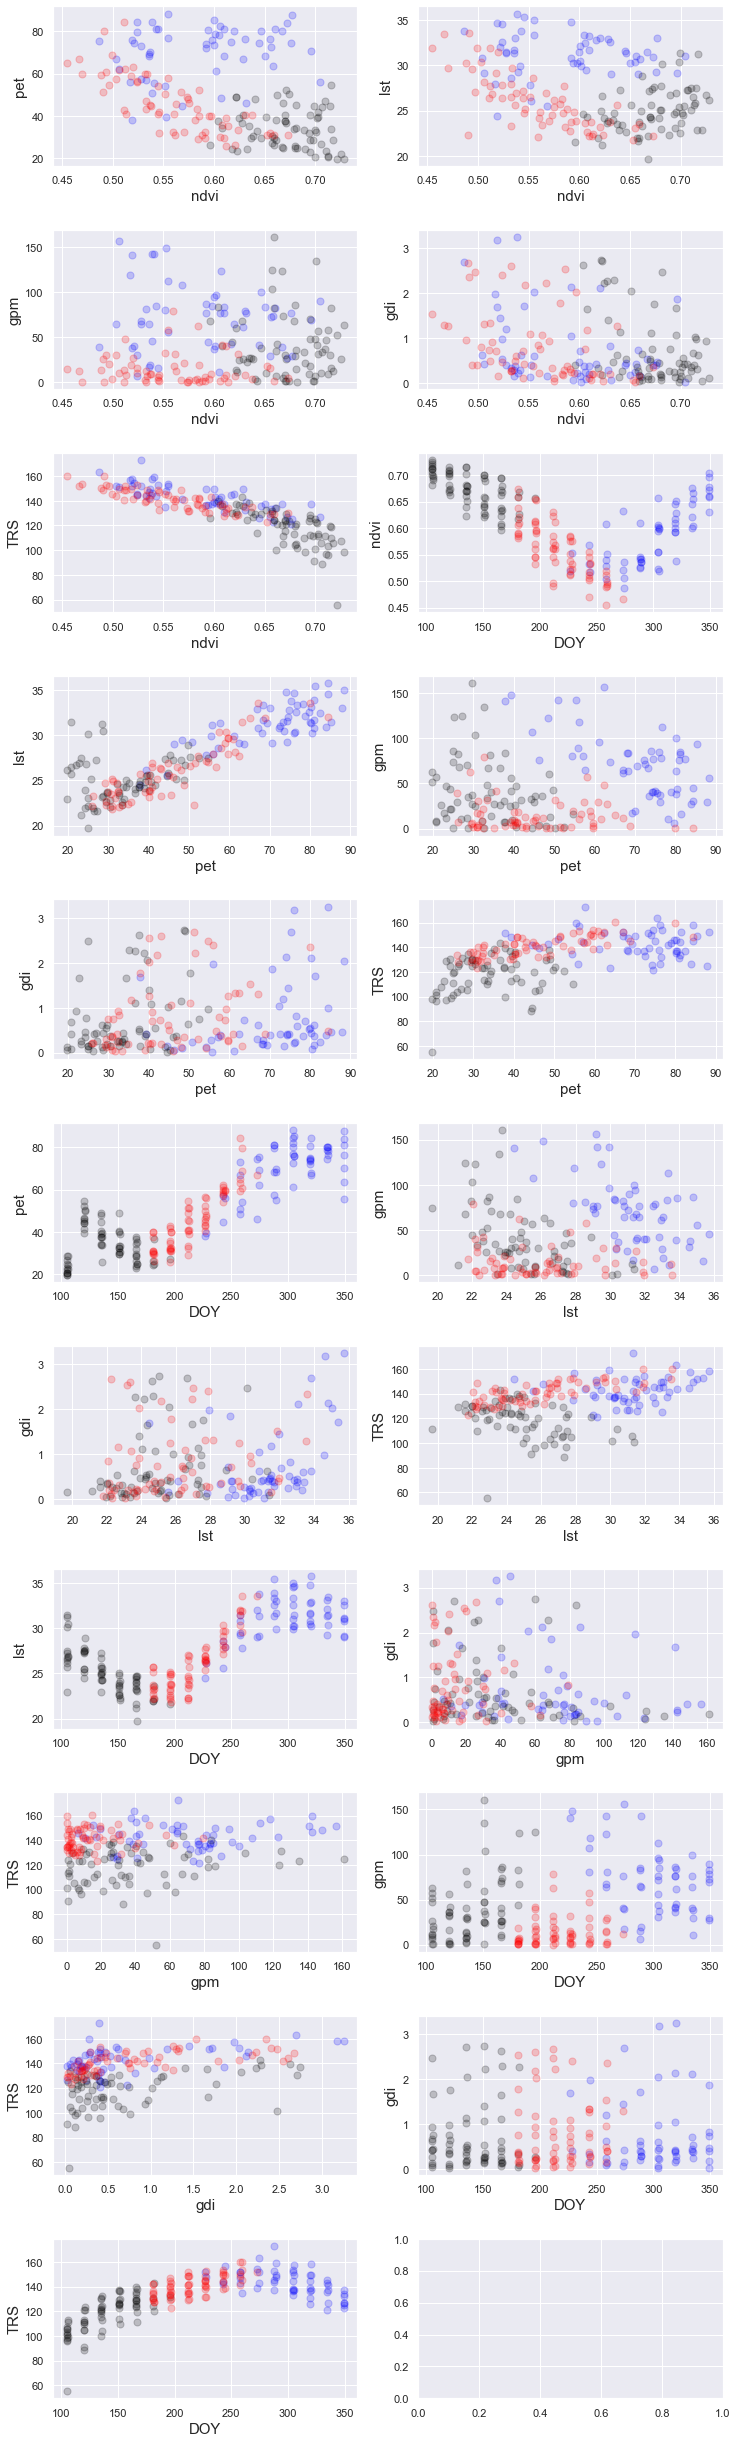

In [45]:
combos = [l for l in itertools.combinations(f_names,2)]

n_vars = len(combos)
n_rows = n_vars//2 + n_vars%2
sns.set(font_scale=1) 
alpha = 0.2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows*4))
fig.subplots_adjust(hspace=0.4)
for i in range(n_vars):
    ax = axes[i//2, i % 2]
    var_1, var2 = combos[i]
    if 'DOY' in combos[i]:
        var_1 = 'DOY'
        var2 = (set(combos[i]) - {'DOY'}).pop()
    ax.scatter(X[y_km ==0,f_names.index(var_1)], X[y_km == 0,f_names.index(var2)], s=50, c='blue', alpha = alpha)
    ax.scatter(X[y_km ==1,f_names.index(var_1)], X[y_km == 1,f_names.index(var2)], s=50, c='black', alpha = alpha)
    ax.scatter(X[y_km ==2,f_names.index(var_1)], X[y_km == 2,f_names.index(var2)], s=50, c='red', alpha = alpha)
    ax.set_xlabel(var_1, fontsize=15)
    ax.set_ylabel(var2, fontsize=15)

* The earliest group is shown in red. The middle group is shown in blue, and the latest group is in black.
* Seasonality is also clearly portrayed by the temperature, precipitation and PET from the DOY 100 to 350.

### Fit a multivariate linear regression for each Sub-harvesting-season
* There are many models we could choose to predict TRS
* A multivariate linear regression is a simplest method. It is easy to interpret and fast to run.
* The statsmodels package provides detailed regression statistics. We use the OLS (ordinary least squares) regressor here.

In [46]:
for name in input_vars + ['TRS']:
    df_tog[name] = df_tog[name].astype(float)

In [47]:
new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
for L, R in ranges:
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[input_vars + ['intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)
    print("\nTRS periods with DOY {} to {}".format(L, R))
    print(model.summary())
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()



TRS periods with DOY 100 to 190
                            OLS Regression Results                            
Dep. Variable:                    TRS   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     22.43
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           2.37e-13
Time:                        15:55:36   Log-Likelihood:                -277.97
No. Observations:                  76   AIC:                             567.9
Df Residuals:                      70   BIC:                             581.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ndvi        -217.45

* The middle period linear regression model (DOY 196-259) appeared to have the best performance in terms of the variance explained
* PET was insignificant in the middle period and GPM was weakly signficant in the other two periods. <br>
Thus it is worth checking if removing PET and GPM respectively could improve the adjusted r-squared or not.
* SM was insignificant in the first and last period, thus it is worth checking if removing SM from these two periods could improve the adjusted r-squared.


### Remvoing PET and GPM

In [48]:
new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
input_var_list = [['ndvi','pet','lst', 'gdi'], 
                  ['ndvi', 'lst', 'gpm', 'gdi'],
                  ['ndvi','pet','lst',  'gdi']
                 ]
for i, (L, R) in enumerate(ranges):
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[input_var_list[i] + ['intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)
    print("\nTRS periods with DOY {} to {}".format(L, R))
    print(model.summary())
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()



TRS periods with DOY 100 to 190
                            OLS Regression Results                            
Dep. Variable:                    TRS   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     27.60
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           7.78e-14
Time:                        15:55:36   Log-Likelihood:                -278.66
No. Observations:                  76   AIC:                             567.3
Df Residuals:                      71   BIC:                             579.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ndvi        -202.24

* Only the middle period benefited from removing PET, but the other two periods did not have better adjusted R-squared after removing GPM from the input feature list. So let's keep the full feature lists minus SM still for all except for the middle period.
* The following scatter plot shows the within-sample predicted versus actual yield along the 1-1 line

In [49]:
new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
input_var_list = [['ndvi','pet','lst', 'gpm','gdi'], 
                  ['ndvi', 'lst', 'gpm', 'gdi'],
                  ['ndvi','pet','lst', 'gpm', 'gdi']
                 ]
for i, (L, R) in enumerate(ranges):
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[input_var_list[i] + ['intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)

with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()


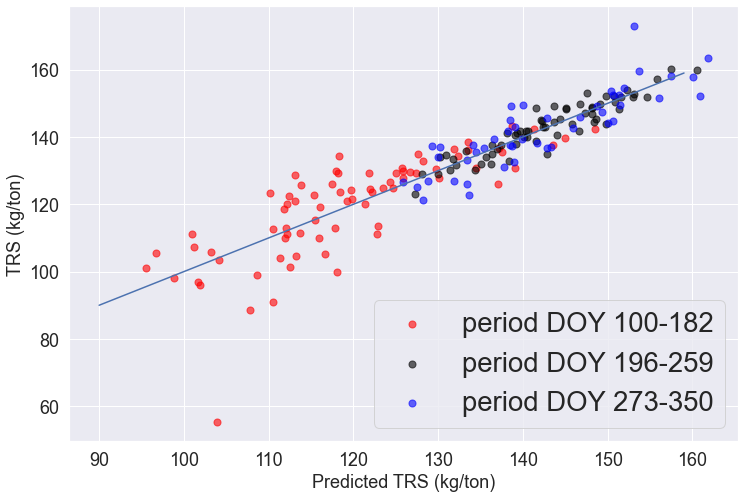

In [50]:
sns.set(font_scale=2.5) 
fig, ax = plt.subplots(figsize=(12,8))
with_pred[with_pred['DOY'] < 190].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='red', alpha=0.6)
with_pred[(with_pred['DOY'] > 190) & (with_pred['DOY'] < 265)].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='black', alpha=0.6)
with_pred[with_pred['DOY'] >270].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='blue', alpha=0.6)
plt.legend(['period DOY 100-182',
'period DOY 196-259',
'period DOY 273-350'])
ax.plot(range(90,160), range(90,160))
plt.xlabel('Predicted TRS (kg/ton)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

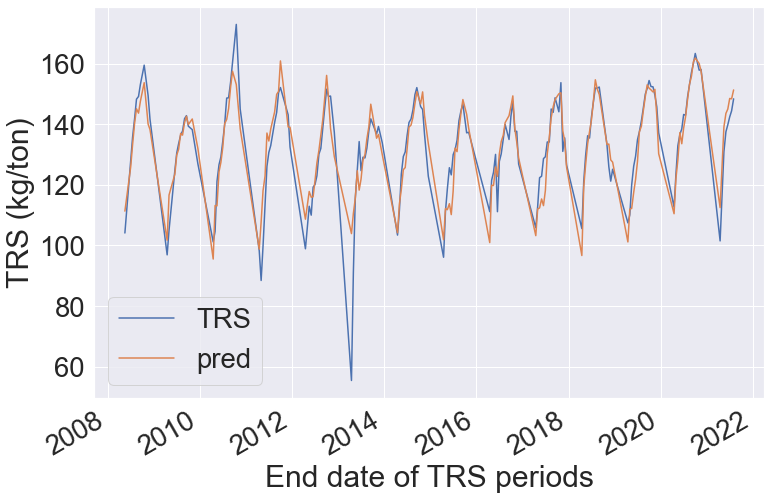

In [51]:
with_pred.set_index('end_date')

fig, ax = plt.subplots(figsize=(12,8))
with_pred.plot(x='end_date', y='TRS', ax=ax)
with_pred.plot(x='end_date', y='pred', ax=ax)
plt.xlabel('End date of TRS periods')
plt.ylabel('TRS (kg/ton)')
plt.show()

* Our model estimated TRS of all periods combined matched well with the Actual, especially during the peak TRS value periods

### Making predictions with the Model coefficients when a most recent period of TRS value was assumed to be available

In [52]:
# the cluster of TRS periods DOY 100-182
coef_early = model_list[0].params
coef_early.pop('intercept')

# the cluster of DOY periods 196-259
coef_mid = model_list[1].params
coef_mid.pop('intercept')

# the cluster of TRS periods DOY 273-350
coef_late = model_list[2].params
coef_late.pop('intercept')

185.4731922973914

* The coefficients of the linear regression models of different periods are stored above.
* Then limit the dataframe to the last 5 TRS periods, including the period to be predicted.
* We use the input variables associated with the middle subharvest period because we are predicting a date within this period.
* Compute the differences in variables between periods.

In [53]:
recent_df = df_tog.sort_values(['year','DOY']).tail()
var_list = coef_mid.index.values # since we are in the middle period
recent_diff = recent_df[var_list].diff()

* Calculate the predicted change in TRS from a previous period by using numpy's dot product function, inputting the `['lst','pet','gpm','ndvi', 'gdi']` differences and the coefficients.
* Since we are in the middle period already, use the middle period parameters.

In [54]:
recent_df['TRS_diff'] = np.dot(recent_diff.values, np.array(coef_mid).reshape(4, -1)).reshape(1,-1)[0]

* Finally, add the predicted change in TRS or _"TRS_diff"_ to the previous periods to get the _"pred_TRS"_

In [55]:
recent_df['pred_TRS'] = [np.nan] + list(recent_df['TRS_diff'].values[1:] + recent_df['TRS'].values[:-1])
recent_df

,DOY,Year,TRS,end_date,doy,year,ndvi,pet,gpm,lst,gdi,TRS_diff,pred_TRS
221,166,2021,139.81,2021-06-15 00:00:00+00:00,166,2021,0.604017,37.688121,83.784042,24.627417,2.625467,NaN,NaN
222,181,2021,142.40,2021-06-30 00:00:00+00:00,181,2021,0.585421,39.996158,18.828690,23.181575,2.546667,-3.427547,136.382453
223,196,2021,144.39,2021-07-15 00:00:00+00:00,196,2021,0.532632,43.016164,0.297834,23.316257,2.608533,2.986332,145.386332
224,212,2021,148.36,2021-07-31 00:00:00+00:00,212,2021,0.490127,51.318742,25.907467,22.262522,2.677562,2.931158,147.321158
225,227,2021,NaN,2021-08-15 00:00:00+00:00,227,2021,0.487106,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Calculate the Mean Squared Error as an evaluation
msr_trs = recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().mean()
print(msr_trs)

2.68424000562437


In [57]:
# Calculate the Mean Squared Error as a fraction of the average TRS
percent_msr = recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().divide(recent_df['TRS']).mean()
print(percent_msr)

0.018720167442383057


### Making predictions by incorporating GFS forecasted precipitation to GPM
In this section, we pad GFS forecasted precipitation for those days where GPM data is not available and use this padded GPM data to predict Brazil sugar yield. Since this prediction model is similar to the prceding GPM-only model, it is unnecessary to explain every steps in the calculation. Rather, we copy over essential code above and derive the final result directly. 

In [58]:
gfs_y.rename(columns={'value': 'gfs'}, inplace=True)
gfs_y.DOY = gfs_y.DOY.astype(int)
df_tog = df_tog.merge(gfs_y[['gfs', 'DOY','year']], on=['DOY', 'year'], how='left')

df_tog.sort_values(['year','DOY'], ascending=True).tail()

,DOY,Year,TRS,end_date,doy,year,ndvi,pet,gpm,lst,gdi,gfs
221,166,2021,139.81,2021-06-15 00:00:00+00:00,166,2021,0.604017,37.688121,83.784042,24.627417,2.625467,54124.491283
222,181,2021,142.40,2021-06-30 00:00:00+00:00,181,2021,0.585421,39.996158,18.828690,23.181575,2.546667,12163.333475
223,196,2021,144.39,2021-07-15 00:00:00+00:00,196,2021,0.532632,43.016164,0.297834,23.316257,2.608533,4936.019627
224,212,2021,148.36,2021-07-31 00:00:00+00:00,212,2021,0.490127,51.318742,25.907467,22.262522,2.677562,16736.223401
225,227,2021,NaN,2021-08-15 00:00:00+00:00,227,2021,0.487106,NaN,NaN,NaN,NaN,4347.575038


In [59]:
for name in ['lst','pet','gfs','ndvi','gdi','TRS']:
    df_tog[name] = df_tog[name].astype(float)

new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
for L, R in ranges:
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[['lst','pet','gfs','ndvi','gdi','intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)
    print("\nTRS periods with DOY {} to {}:".format(L, R))
    print(model.summary())
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()



TRS periods with DOY 100 to 190:
                            OLS Regression Results                            
Dep. Variable:                    TRS   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     21.80
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           4.30e-13
Time:                        15:55:36   Log-Likelihood:                -278.63
No. Observations:                  76   AIC:                             569.3
Df Residuals:                      70   BIC:                             583.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lst           -1.7

* Only the last period performed slightly better than using GPM
* Both the first and second period have better fit or higher r-squared with the GPM data.

In [60]:
# the cluster of TRS periods DOY 100-182
coef_early = model_list[0].params
coef_early.pop('intercept')

# the cluster of DOY periods 196-259
coef_mid = model_list[1].params
coef_mid.pop('intercept')

# the cluster of TRS periods DOY 273-350
coef_late = model_list[2].params
coef_late.pop('intercept')

203.54124417263037

In [61]:
# the cluster of TRS periods DOY 100-182
coef_early = model_list[0].params
coef_early.pop('intercept')

# the cluster of DOY periods 196-259
coef_mid = model_list[1].params
coef_mid.pop('intercept')

# the cluster of TRS periods DOY 273-350
coef_late = model_list[2].params
coef_late.pop('intercept')

recent_df = df_tog.sort_values(['year','DOY']).tail()
var_list = coef_mid.index.values

recent_diff = recent_df[var_list].diff() 
recent_df['TRS_diff'] = np.dot(recent_diff.values, np.array(coef_mid).reshape(len(input_vars), -1)).reshape(1,-1)[0]

recent_df['pred_TRS'] = [np.nan] + list(recent_df['TRS_diff'].values[1:] + recent_df['TRS'].values[:-1])
recent_df


,DOY,Year,TRS,end_date,doy,year,ndvi,pet,gpm,lst,gdi,gfs,TRS_diff,pred_TRS
221,166,2021,139.81,2021-06-15 00:00:00+00:00,166,2021,0.604017,37.688121,83.784042,24.627417,2.625467,54124.491283,NaN,NaN
222,181,2021,142.40,2021-06-30 00:00:00+00:00,181,2021,0.585421,39.996158,18.828690,23.181575,2.546667,12163.333475,-4.093519,135.716481
223,196,2021,144.39,2021-07-15 00:00:00+00:00,196,2021,0.532632,43.016164,0.297834,23.316257,2.608533,4936.019627,3.033324,145.433324
224,212,2021,148.36,2021-07-31 00:00:00+00:00,212,2021,0.490127,51.318742,25.907467,22.262522,2.677562,16736.223401,1.084798,145.474798
225,227,2021,NaN,2021-08-15 00:00:00+00:00,227,2021,0.487106,NaN,NaN,NaN,NaN,4347.575038,NaN,NaN


In [62]:
msr_trs = recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().mean()
print(msr_trs)

3.537347927428916


In [63]:
# Calculate the Mean Squared Error as a fraction of the average TRS
percent_msr = recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().divide(recent_df['TRS']).mean()
print(percent_msr)

0.024535951908558135


### Backtesting linear regression on subharvesting groups

We approach backtesting by the leave-one-year-out method. In this method, we provide cross-validation on the existing model by training on all data except one year, and then testing on the left out year.

The following function will apply the leave-one-year-out method on an input dataframe with features and true TRS value, will print metrics regarding the multivariate linear regression models and predictions using the left out year. 

We will apply this function to each of the 3 sub-harvesting seasons (dividing the days of the year into groups by weather patterns).

In [64]:
def leave_one_year_out_backtest(df_agg, feature_cols, predicted_col, yearindex):
    """
    leave one year out and train on the remaining years, then test on the left out year
    :param df_agg: cleaned dataframe with features and true yields
    :param feature_cols: list of features
    :param predicted_col: column name for output metric of model
    :param yearindex: column name for year
    :return: 
        backtested dataframe
        dictionary of evaluation metrics including:
            list of rsquared values for the models
            list of adjusted rsquared values for the models
            list of mean squared errors for the predictions 
            list of mean absolute errors for the predictions
            list of mean absolute percent errors for the predictions
    """
    df_agg['pred_'+predicted_col] = np.nan
    score_dict = {
        'rsquared': [],
        'rsquared_adj': [],
        'msr': [],
        'mae': [],
        'percent_mae': []
    }
    if len(df_agg[yearindex].unique()) <= 1:
        raise exceptions.IncompleteSourceDataDownloadError(
            "Input Data has no more than one year. Can not proceed with leave one year out backtesting")
    for testyear in sorted(df_agg[yearindex].unique()):
        Y = df_agg.loc[df_agg[yearindex] != testyear, predicted_col]
        X = df_agg.loc[df_agg[yearindex] != testyear, feature_cols]
        model = sm.OLS(Y, X).fit()
        score_dict['rsquared'].append(model.rsquared)
        score_dict['rsquared_adj'].append(model.rsquared_adj)
        try:
            X_pred = df_agg.loc[df_agg[yearindex] == testyear, feature_cols]
            Y_pred = model.predict(df_agg.loc[df_agg[yearindex] == testyear, feature_cols])
            Y_actual = df_agg.loc[df_agg[yearindex] == testyear, predicted_col]
            df_agg.loc[df_agg[yearindex] == testyear, 'pred_'+predicted_col] = Y_pred
            msr = np.square(Y_pred.subtract(Y_actual)).mean()
            mae = Y_pred.subtract(Y_actual).abs().mean()
            percent_mae = Y_pred.subtract(Y_actual).abs().divide(Y_actual).mean()
            score_dict['msr'].append(msr)
            score_dict['mae'].append(mae)
            score_dict['percent_mae'].append(percent_mae)
        except:
            print("There is an issue in {}.".format(testyear))
            pass
    return df_agg, score_dict

In [65]:
# backtesting model using leave-one-year-out approach
def get_subharvest_group(doy):
    """
    label each entry by one of the three subharvest seasons, based off day of the year
    :param doy: integer value indicating day of the year
    :return: an integer with value 0, 1, or 2 representing one of the three subharvest groups
    """
    return np.digitize(doy, bins=[100, 190, 265], right=False) - 1
        
def run_backtesting_all_subharvest_models(input_var_list):
    """
    run backtesting on each subharvest group individually and return backtesting metrics
    :param input_var_list: list of features for each subharvest group, length is number of subharvest groups
    :return:
        backtested dataframe
        dataframe containing metrics (rsquared, adjusted rsquared, mse, mae, percent mae) for each group
    """
    new_dat_list = []
    metric_df = df_tog[['Year', 'DOY']]
    metric_df.rename(columns={'Year': 'Year_out'}, inplace=True)
    metric_df['subharvest_group'] = metric_df['DOY'].apply(get_subharvest_group)
    metric_df = metric_df[['Year_out', 'subharvest_group']].drop_duplicates()

    ranges = [(100, 190), (190, 265), (265,350)]
    
    for i, (L, R) in enumerate(ranges):
        sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
        sub_dat['intercept'] = 1.
        feature_cols = input_var_list[i] + ['intercept']
        X_with_pred, score_dict = leave_one_year_out_backtest(sub_dat, feature_cols, 'TRS', 'Year')
        new_dat_list.append(X_with_pred)
        metric_df.loc[
            metric_df['subharvest_group'] == i, 
            ['rsquared', 'rsquared_adj', 'msr', 'mae', 'percent_mae']
        ] = pd.DataFrame(score_dict).values
    with_pred = pd.concat(new_dat_list, axis=0)
    return with_pred, metric_df
    
input_var_list = [
    ['ndvi','pet','lst', 'gpm', 'gdi'], 
    ['ndvi', 'lst', 'gpm', 'gdi'], 
    ['ndvi','pet','lst', 'gpm', 'gdi']
]
with_pred, metric_df = run_backtesting_all_subharvest_models(input_var_list)

In [66]:
# display metrics from backtesting
metric_df.sort_values(['subharvest_group', 'Year_out']).head()

,Year_out,subharvest_group,rsquared,rsquared_adj,msr,mae,percent_mae
0,2008,0,0.612050,0.583524,28.907561,4.606172,0.042614
16,2009,0,0.605589,0.575709,46.383915,4.939318,0.047213
33,2010,0,0.606117,0.575345,36.370605,5.417371,0.047698
50,2011,0,0.632798,0.604111,203.538881,12.207871,0.117534
67,2012,0,0.612509,0.582701,36.444989,5.215891,0.048647


When backtesting, we evaluate model and prediction performance based off a few metrics:
- R-squared (rsquared): The R-squared value describes the proportion of variance of the output variable (in our case, TRS) that the model is able to capture. This value ranges from 0 to 1. For example, an R-squared value of 0.9 means that the model is able to describe 90% of the variance of the output variable. When evaluating our model, we can say the model is performing well with respect to explained variance if the R-squared value is close to 1. 
- Adjusted R-squared (rsquared_adj): The adjusted R-squared value is similar to the R-squared value, but adjusted for the number of input variables used. Adjusted R-squared value would decrease when an additional input variable does not improve the explained variance more than random chance. The R-squared and adjusted R-squared values are often similar.
- Mean Squared Error (msr): The mean squared error is a metric to evaluate the model's predictions. We define error as the difference between the actual and predicted output variable values (TRS here). To calculate mean squared error, we take each error term, square it, and then take the mean of all the squared error terms. We try to minimize mean squared error when building a model.
- Mean Absolute Error (mae): The mean absolute error is also a metric to evaluate the model's predictions. The only difference between mean absolute error and mean squared error is that we take the absolute value of the error terms, instead of the square. 
- Mean Absolute Percent Error (percent_mae): Mean absolute percent error is similar to the mean absolute error, except we divide the absolute value of the error by the actual value before taking the mean. 

In [67]:
# average out-of-sample test years to get one summary statistic per model
metric_df.drop('Year_out', axis=1).groupby('subharvest_group').mean()

,rsquared,rsquared_adj,msr,mae,percent_mae
subharvest_group,,,,,
0,0.621296,0.591971,113.984962,7.745484,0.072650
1,0.873256,0.863935,11.873141,2.772526,0.019546
2,0.745440,0.711334,54.869309,5.680355,0.039522


In [68]:
def plot_metric_one_year_left_out(metric, metric_title):
    """
    generate a plot of a given metric versus year left out in backtesting
    :param metric: the column name of the metric in the metric_df dataframe
    :param metric_title: a string that will be the title of the y axis
    """
    sns.set(font_scale=2) 
    fig, ax = plt.subplots(figsize=(12,8))
    metric_df[metric_df['subharvest_group'] == 0].plot(x='Year_out', y=metric, fontsize=18, kind='line', 
                                                                  legend=False, ax=ax, c='red')
    metric_df[metric_df['subharvest_group'] == 1].plot(x='Year_out', y=metric, fontsize=18, kind='line', 
                                                                  legend=False, ax=ax, c='black')
    metric_df[metric_df['subharvest_group'] == 2].plot(x='Year_out', y=metric, fontsize=18, kind='line', 
                                                                  legend=False, ax=ax, c='blue')
    plt.legend(['period DOY 100-182',
    'period DOY 196-259',
    'period DOY 273-350'], loc='best')
    plt.xlabel('Year left out in training (Year used in testing)', fontsize=18)
    plt.ylabel(metric_title, fontsize=18)
    plt.show()

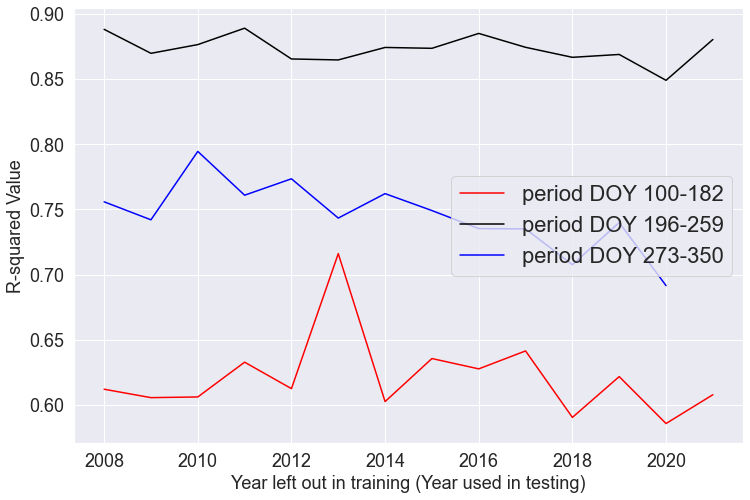

In [69]:
plot_metric_one_year_left_out('rsquared', 'R-squared Value')

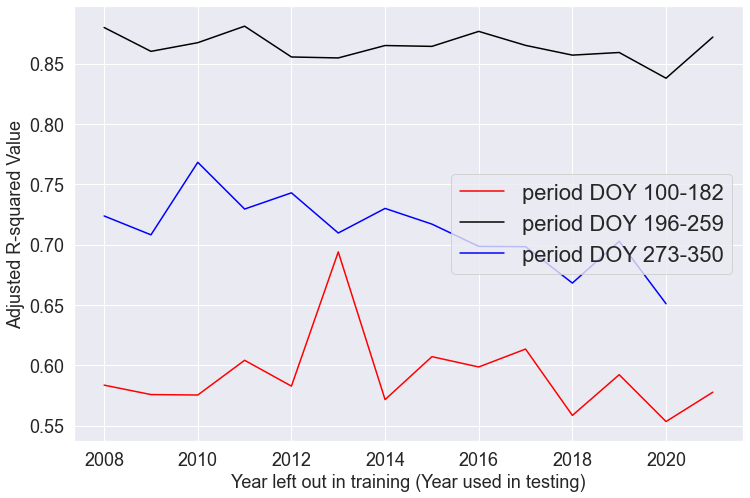

In [70]:
plot_metric_one_year_left_out('rsquared_adj', 'Adjusted R-squared Value')

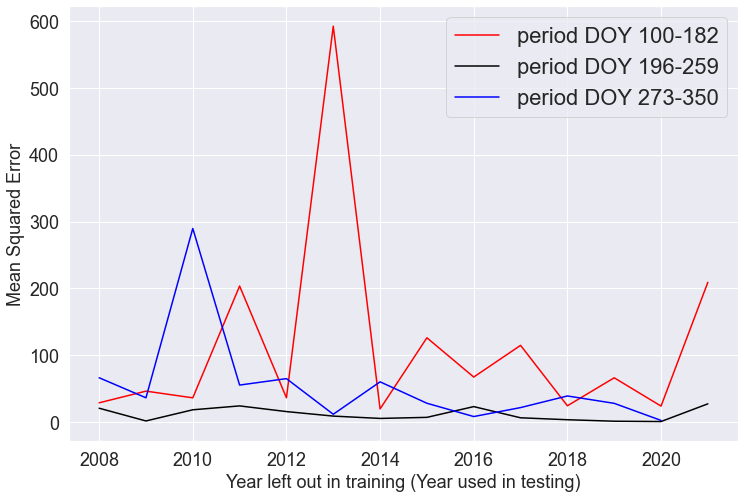

In [71]:
plot_metric_one_year_left_out('msr', 'Mean Squared Error')

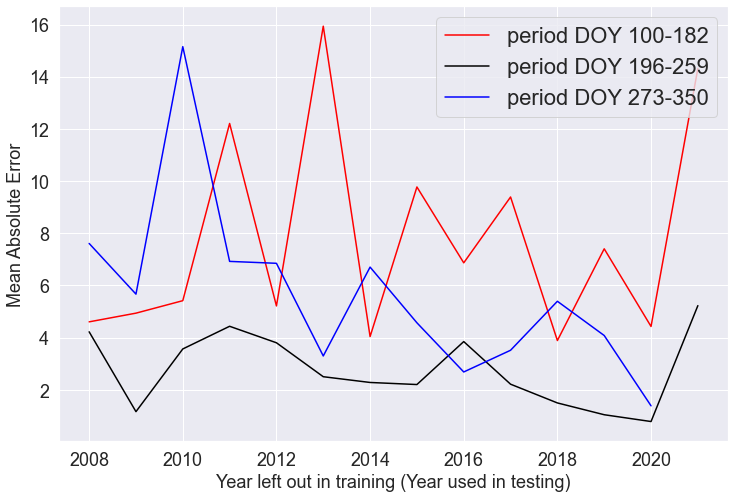

In [72]:
plot_metric_one_year_left_out('mae', 'Mean Absolute Error')

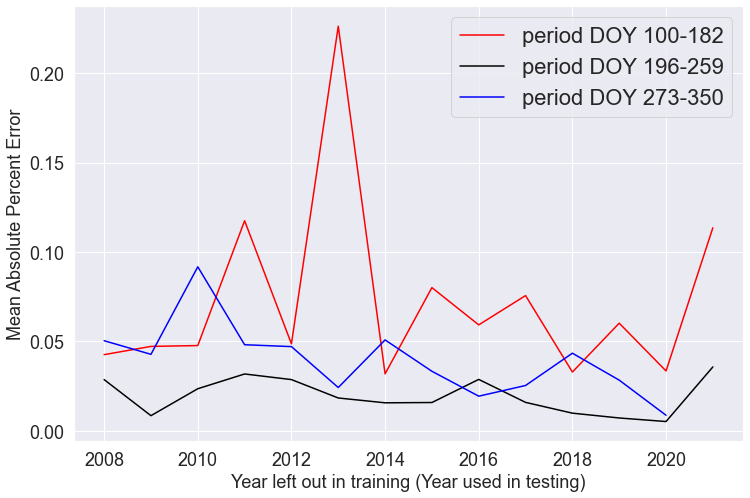

In [73]:
plot_metric_one_year_left_out('percent_mae', 'Mean Absolute Percent Error')

### Backtesting on model with GFS included

We now apply backtesting on the models that incorporate GFS data.

In [74]:
input_var_list = [
    ['lst','pet','gfs','ndvi','gdi'],
    ['lst','pet','gfs','ndvi','gdi'],
    ['lst','pet','gfs','ndvi','gdi']
]
with_pred, metric_df = run_backtesting_all_subharvest_models(input_var_list)
# average out-of-sample test years to get one summary statistic per model
metric_df.drop('Year_out', axis=1).groupby('subharvest_group').mean()

,rsquared,rsquared_adj,msr,mae,percent_mae
subharvest_group,,,,,
0,0.614170,0.584293,111.454331,7.512749,0.071098
1,0.843284,0.828609,15.265911,3.251613,0.022896
2,0.747752,0.713966,71.720836,6.609320,0.045349


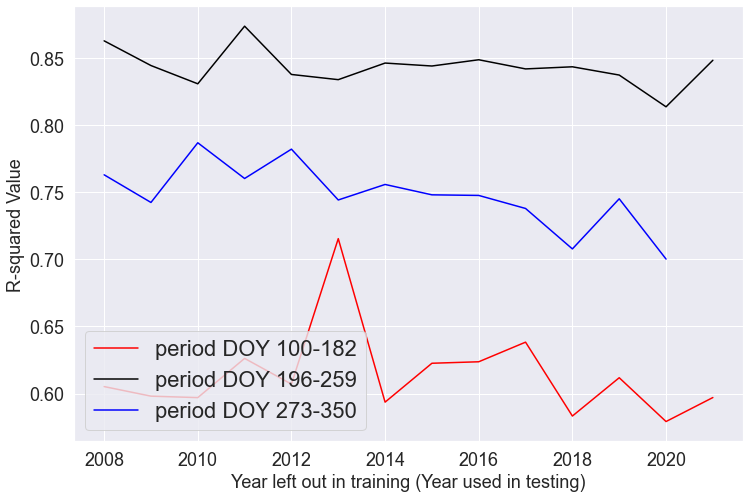

In [75]:
plot_metric_one_year_left_out('rsquared', 'R-squared Value')

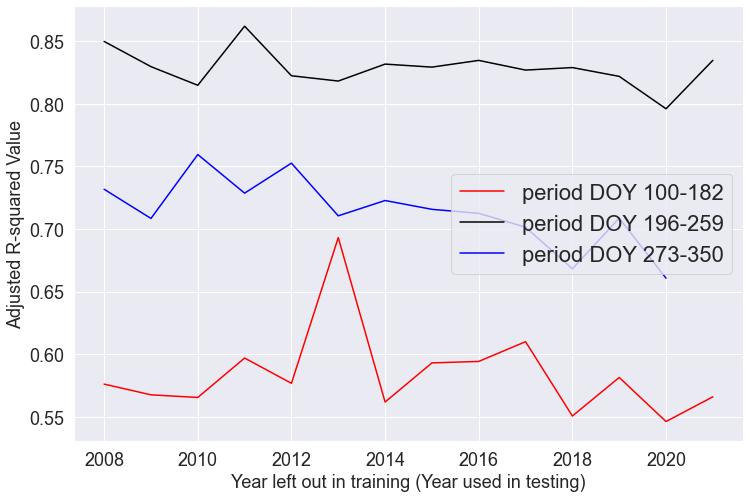

In [76]:
plot_metric_one_year_left_out('rsquared_adj', 'Adjusted R-squared Value')

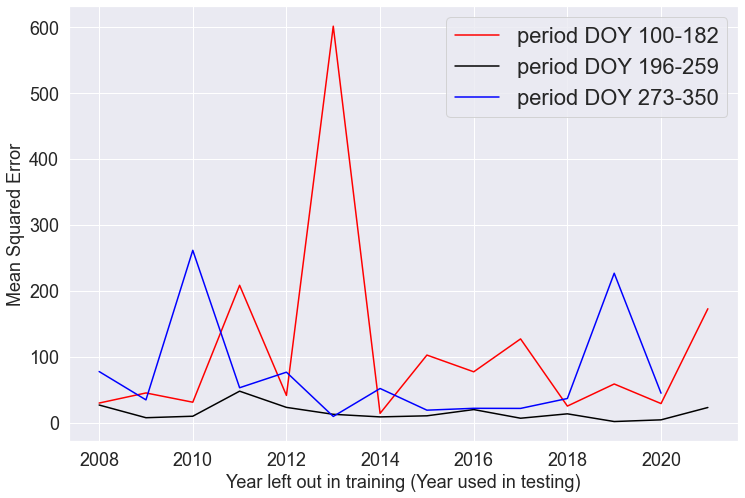

In [77]:
plot_metric_one_year_left_out('msr', 'Mean Squared Error')

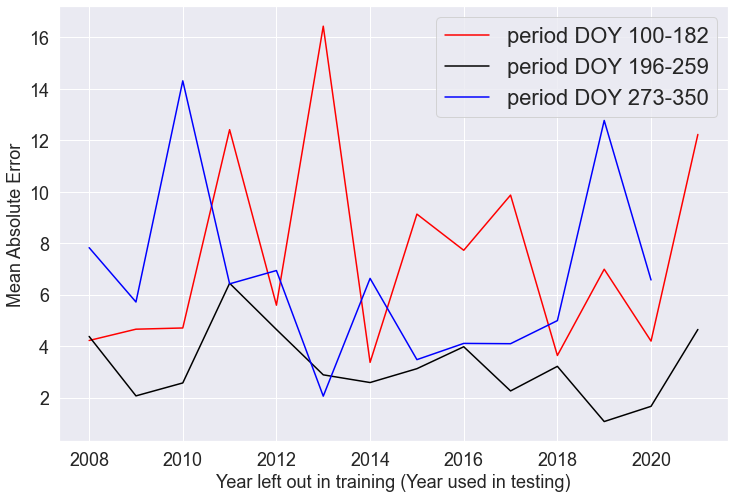

In [78]:
plot_metric_one_year_left_out('mae', 'Mean Absolute Error')

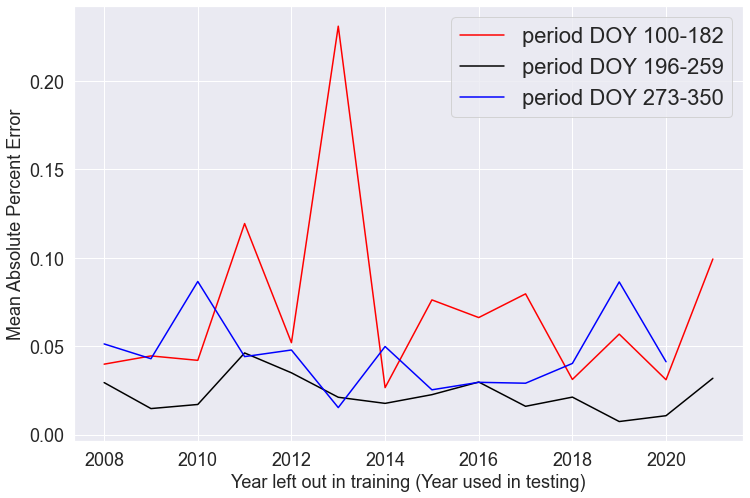

In [79]:
plot_metric_one_year_left_out('percent_mae', 'Mean Absolute Percent Error')

### Final Notes
* You can use this model to predict future periods of TRS where we have available Temperature (LST), Actual Precipitation (GPM), Forecasted Precipitation (GFS), Potential Evapotranspiration (PET), Gro Drought Index (GDI) and NDVI data. 
* When some weather variables are not available for the predicted period yet, we are not able to make a TRS prediction.
* The example in this notebook predicted the TRS period up to the end_date "2021-07-30". For each period, we consider the change in weather variables from the previous period to predict the expected difference in TRS, and then this difference is added to the previous period's value to get to a predicted value.
* The prediction performance improved slightly by incorporating forecasted precipitation. Our method predicted the last 3 periods of TRS with an average Mean Squared Error of 3.06% of the average actual TRS without GFS. The error is reduced to 3.00% after adding GFS.
* Through backtesting using the leave-one-year-out method, we confirm that our model generalizes well.